In [234]:
"""import the required libraries"""
import numpy as np 
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import math
from scipy.stats import multivariate_normal

In [235]:
"""read the data and preprocess it"""
input_data = open("/Users/kavinarasu/Desktop/GMM_dataset.txt", "r")
ipdata = input_data.read().splitlines()
new_data = [x.split("  ") for x in ipdata] 
new_data = np.asarray(new_data)
new_data = np.delete(new_data,0,1)
new_data = new_data.astype(float)
data=new_data

In [236]:
no_of_clusters = 3
def euc_dist(a,b):
    dist = math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    return dist
def split_data(assign_centroid,data):
    centroid1=0
    centroid2=0
    centroid3=0
    centroid1_data=[]
    centroid2_data=[]
    centroid3_data=[]
    centroid1_data_sum=np.zeros((1,2))
    centroid2_data_sum=np.zeros((1,2))
    centroid3_data_sum=np.zeros((1,2))
    for i in range(assign_centroid.shape[0]):
        if assign_centroid[i][0] == 1:
            centroid1 = centroid1 +1
            centroid1_data = np.append(centroid1_data,data[i,:])
        elif assign_centroid[i][1] ==1:
            centroid2 = centroid2 +1
            centroid2_data = np.append(centroid2_data,data[i,:])
        else:
            centroid3 = centroid3 +1
            centroid3_data = np.append(centroid3_data,data[i,:])

    centroid1_data=centroid1_data.reshape(centroid1,2)
    centroid2_data=centroid2_data.reshape(centroid2,2)
    centroid3_data=centroid3_data.reshape(centroid3,2)
    return centroid1_data,centroid2_data,centroid3_data
    

def find_mse(data,centroid):
    mse=0
    for i in range(data.shape[0]):
        euclidean_dist=[]
        for j in range(centroid.shape[0]):
            dist = euc_dist(data[i,:], centroid[j,:])
            euclidean_dist = np.append(euclidean_dist, dist)
        mse = mse + np.min(euclidean_dist)
    return mse

def k_means (data,no_of_clusters):
    mse_list=[]
    min_mse_centroid=[]
    min_mse_assign_centroid=[]
    mse_min=10000
    for i in range(10):
        cent_euc=1
        idx = np.random.randint(1500, size=no_of_clusters)
        centroid=data[idx,:]
        c_old=centroid
        iteration=1
        while(cent_euc>0):
            """ASSIGNMENT STEP"""     
            iteration=iteration+1
            assign_centroid=np.zeros((1500,3))
            for i in range(data.shape[0]):
                euclidean_dist=[]
                for j in range(centroid.shape[0]):
                    dist = euc_dist(data[i,:], centroid[j,:])
                    euclidean_dist = np.append(euclidean_dist, dist)
                assign_centroid[i][np.argmin(euclidean_dist)] =1        

            """UPDATE STEP"""
            centroid1_data,centroid2_data,centroid3_data=split_data(assign_centroid,data)
            c_new=np.zeros((3,2))
            c_new[0,:]=centroid1_data.mean(axis=0)
            c_new[1,:]=centroid2_data.mean(axis=0)
            c_new[2,:]=centroid3_data.mean(axis=0)
            if(np.array_equal(centroid,c_new)):
                cent_euc=0
                mse_list = np.append(mse_list,find_mse(data,c_new))
                temp_mse_min=np.min(mse_list)
                if(temp_mse_min<mse_min):
                    mse_min=temp_mse_min
                    min_mse_centroid=c_new
                    min_mse_assign_centroid=assign_centroid
            centroid=c_new
    centroid1_data,centroid2_data,centroid3_data=split_data(min_mse_assign_centroid,data)
    print("best cluster from all the iterations")
#     print(min_mse_assign_centroid)
    return min_mse_centroid,min_mse_assign_centroid


best cluster from all the iterations


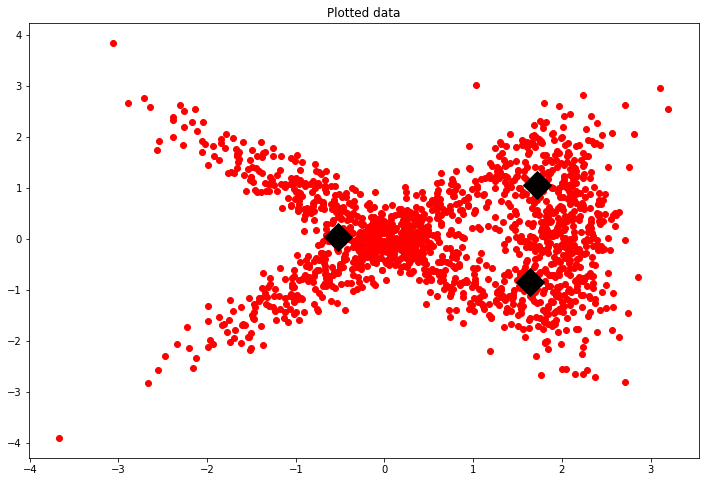

In [237]:
"""initialization step"""
#centroids taken from output of K-MEANS
mean,gamma =k_means(data,no_of_clusters)
plt.plot(data[:,0],data[:,1],'ro')
l=plt.plot(mean[:,0],mean[:,1],'kD')
plt.setp(l,'markersize',20)
plt.title('Plotted data')
plt.rcParams['figure.figsize']=[12,8]

In [238]:
print(mean)
print(gamma)

[[ 1.724763    1.04927424]
 [-0.52016677  0.03882836]
 [ 1.64650399 -0.85083626]]
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [239]:
covar=np.zeros((3,2,2))
pi=np.zeros(3)
lhood=[]
def calc_pi(gamma,pi):
    Nk=gamma.sum(axis=0)
    pi[0]=Nk[0]/gamma.shape[0]
    pi[1]=Nk[1]/gamma.shape[0]
    pi[2]=Nk[2]/gamma.shape[0]
    return pi

    
def calc_covar(data,covar,gamma):
    sk=gamma.sum(axis=0)
    print(sk)
    for i,mu in enumerate(mean):
        skdata=np.zeros((2,2))
        for j,xi in enumerate(data):
            a=data[j]-mean[i]
            skdata=skdata+(gamma[j,i]*np.matmul(np.resize(a,(2,1)),np.resize(a,(1,2))))
        covar[i]=skdata/sk[i]
    return covar

def loglikelyhood(data,mean,covar,pi,lhood):
    lhsum=0
    for i,xi in enumerate(data):
        clustsum=0
        for j,clust in enumerate(mean):
            clustsum=clustsum+pi[j]*multivariate_normal.pdf(data[i],mean=mean[j], cov=covar[j])
        clustsum=np.log(clustsum)
        lhsum=lhsum+clustsum
    lhood=np.append(lhood,lhsum)
    return lhood
    
pi = calc_pi(gamma,pi)
covar = calc_covar(data,covar,gamma)
lhood = loglikelyhood(data,mean,covar,pi,lhood)

def calc_mean(data,mean,gamma):
    Nk=gamma.sum(axis=0)
    for i,mu in enumerate(mean):
        Nkdata=np.asfarray([0,0])
        for j,xi in enumerate(data):
            Nkdata=Nkdata+(gamma[i,0]*data[j])
        mean[i]=Nkdata/Nk[i]
    return mean

def estimation(data,mean,covar):
    for i, xi in enumerate(data):
        var0 = multivariate_normal.pdf(data[i],mean=mean[0], cov=covar[0])
        var1 = multivariate_normal.pdf(data[i],mean=mean[1], cov=covar[1])
        var2 = multivariate_normal.pdf(data[i],mean=mean[2], cov=covar[2])
        gamma[i,0]=(pi[0]*var0)/((pi[0]*var0)+(pi[1]*var1)+(pi[2]*var2))
        gamma[i,1]=(pi[1]*var1)/((pi[0]*var0)+(pi[1]*var1)+(pi[2]*var2))
        gamma[i,2]=(pi[2]*var2)/((pi[0]*var0)+(pi[1]*var1)+(pi[2]*var2))
    return gamma


def maximization(data,mean,covar,gamma,pi):
    mean=calc_mean(data,mean,gamma)
    covar = calc_covar(data,covar,gamma)
    pi = calc_pi(gamma,pi)
    return mean,covar,pi

def mainfunc(data,mean,covar,gamma,pi,lhood):
    for i in range(10):
        gamma = estimation(data,mean,covar)
        print(gamma.sum(axis=1))
        mean,covar,pi = maximization(data,mean,covar,gamma,pi)
        lhood=loglikelyhood(data,mean,covar,pi,lhood)
    print(lhood)
    return lhood,mean,covar,gamma,pi
    
lhood,mean,covar,gamma,pi = mainfunc(data,mean,covar,gamma,pi,lhood)



[375. 728. 397.]
[1. 1. 1. ... 1. 1. 1.]
[360.26882095 767.9319439  371.79923516]
[1. 1. 1. ... 1. 1. 1.]
[321.14750945 716.62947878 462.22301177]
[1. 1. 1. ... 1. 1. 1.]
[354.2159501  698.04011994 447.74392996]
[1. 1. 1. ... 1. 1. 1.]
[386.82366819 676.49558395 436.68074785]
[1. 1. 1. ... 1. 1. 1.]
[416.34380619 642.4806572  441.17553661]
[1. 1. 1. ... 1. 1. 1.]
[438.88886531 592.44903276 468.66210193]
[1. 1. 1. ... 1. 1. 1.]
[456.4081631  527.14928712 516.44254979]
[1. 1. 1. ... 1. 1. 1.]
[474.98418137 452.83494923 572.1808694 ]
[1. 1. 1. ... 1. 1. 1.]
[504.07791768 375.06782066 620.85426166]
[1. 1. 1. ... 1. 1. 1.]
[552.61649242 282.53404981 664.84945777]
[-4531.81686235 -4628.82648362 -4607.29412041 -4582.65961777
 -4581.41494478 -4588.70340657 -4569.10701615 -4541.55403361
 -4540.51201626 -4595.43315077 -4669.29247547]


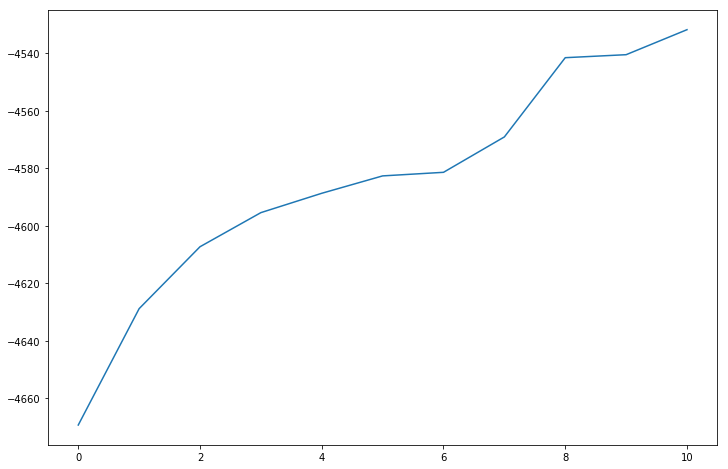

In [246]:
plt.plot(lhood)

In [242]:
import itertools
import matplotlib as mpl
from sklearn import mixture
from scipy import linalg

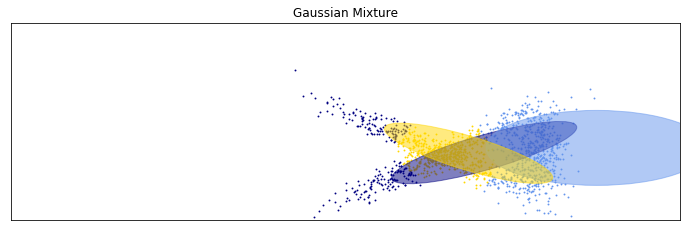

In [248]:
color_iter = itertools.cycle(['navy', 'cornflowerblue', 'gold'])

def plot_results(X, Y_, means, covariances,index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(data)
plot_results(data, gmm.predict(data), mean, covar, 0,
             'Gaussian Mixture')
plt.show()